In [1]:
using CSV
using DataFrames
using Turing
using Logging
using StatisticalRethinking
using StatisticalRethinking: link  # import explicitly, because Turing has link method also
using StatisticalRethinkingPlots
using StatsBase
using Random
using LaTeXStrings
using StatsPlots

using Dagitty

default(label=false)
Logging.disable_logging(Logging.Warn);

# 5.1 Spurious association

Code 5.1

In [2]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage);

Code 5.2

In [3]:
std(d.MedianAgeMarriage)

1.2436303013880823

Code 5.3

In [4]:
Random.seed!(100)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
m5_1_df = DataFrame(m5_1)
prior = sample(model_m5_1([0], [0]), Prior(), 1000)
prior_df = DataFrame(prior);

Code 5.4

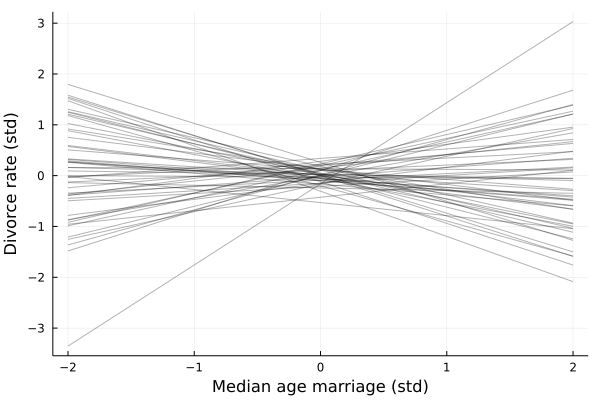

In [5]:
# calculate μ for every prior sample on age=-2 and age=2
bounds = [-2, 2]
μ = link(prior_df, [:a, :bA], bounds)
μ = hcat(μ...);

p = plot(xlab="Median age marriage (std)", ylab="Divorce rate (std)")
for μₚ ∈ first(eachrow(μ), 50)
    plot!(bounds, μₚ; c=:black, alpha=0.3)
end
display(p)

Code 5.5

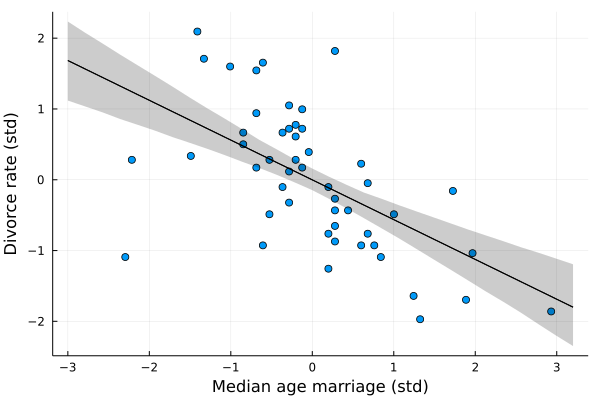

In [6]:
A_seq = range(-3, 3.2; length=30)

μ = link(m5_1_df, [:a, :bA], A_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:A, :D; xlab="Median age marriage (std)", ylab="Divorce rate (std)")
plot!(A_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.6

In [7]:
Random.seed!(100)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
m5_2_df = DataFrame(m5_2);

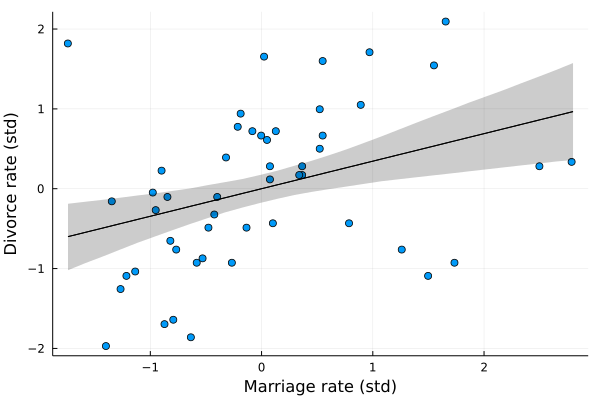

In [8]:
M_seq = range(-1.74, 2.8; length=30)

μ = link(m5_2_df, [:a, :bM], M_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:M, :D; xlab="Marriage rate (std)", ylab="Divorce rate (std)")
plot!(M_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.7

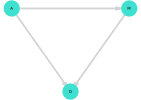

In [9]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
drawdag(g, [0, 1, 2], [0, 1, 0])

Code 5.8

In [10]:
g = Dagitty.DAG(:A => :M, :A => :D)
implied_conditional_independencies(g)

1-element Vector{ConditionalIndependence}:
 ConditionalIndependence(:D, :M, [:A])

Code 5.9

In [11]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
implied_conditional_independencies(g)

ConditionalIndependence[]

Code 5.10

In [12]:
@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3)
precis(m5_3_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │  0.0015  0.1026  -0.1768   0.0045    0.163     ▁▁▁▄██▄▁ │
│    bA │ -0.6043  0.1619  -0.8586  -0.5983  -0.3446   ▁▁▃▆██▆▃▁▁ │
│    bM │  -0.064  0.1575   -0.315  -0.0647   0.1952  ▁▁▃▅███▄▂▁▁ │
│     σ │   0.824  0.0793   0.7055   0.8181   0.9662  ▁▂▄▇█▅▃▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 5.11

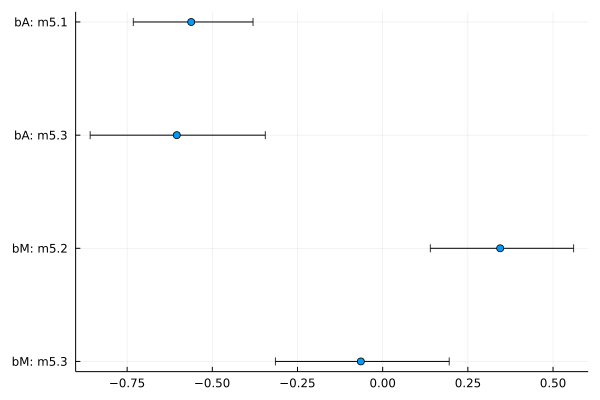

In [13]:
coeftab_plot(m5_1_df, m5_2_df, m5_3_df; pars=(:bA, :bM), names=["m5.1", "m5.2", "m5.3"])

Code 5.12

In [14]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age));

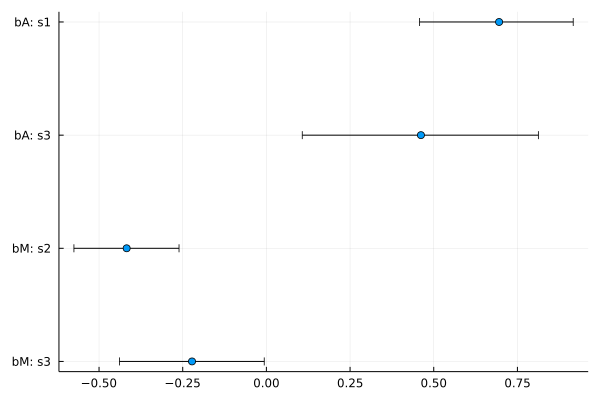

In [15]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

In [16]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age .+ mar));

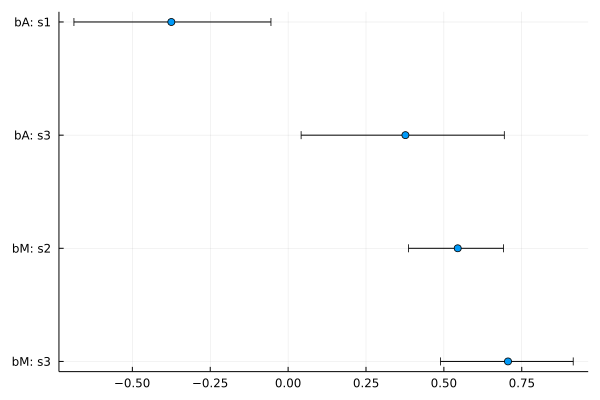

In [17]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

Code 5.13

In [18]:
Random.seed!(100)

@model function model_m5_4(A, M)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ = @. a + bAM * A
    M ~ MvNormal(μ, σ)
end

m5_4 = sample(model_m5_4(d.A, d.M), NUTS(), 1000)
m5_4_df = DataFrame(m5_4);

Code 5.14

In [19]:
mu = link(m5_4_df, [:a, :bAM], d.A);
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_resid = mu_mean .- d.M;

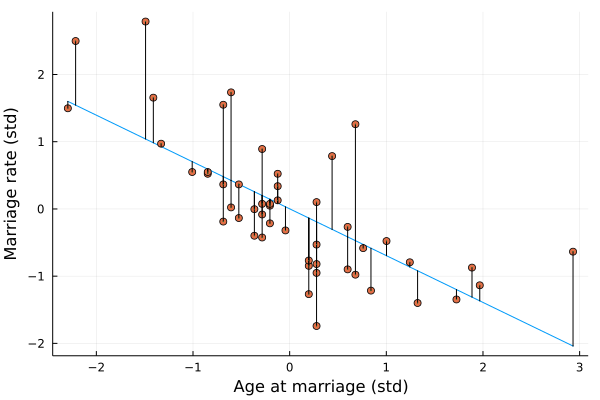

In [20]:
# Side-note: how to plot the residuals
# getting yerr - list of 2-tuples with distance to the regression line
yerr = collect(zip(-clamp.(mu_resid, -Inf, -0.0), clamp.(mu_resid, 0, Inf)));

plot(d.A, mu_mean; xlab="Age at marriage (std)", ylab="Marriage rate (std)")
scatter!(d.A, d.M)
scatter!(d.A, d.M; yerr=yerr, markersize=0)

Code 5.15

In [21]:
fun = (r,(a,m)) -> r.a + r.bA*a + r.bM*m
mu = link(m5_3_df, fun, zip(d.A, d.M))
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...);

fun = (r, (a,m)) -> Normal(r.a+r.bA*a+r.bM*m, r.σ)
D_sim = simulate(m5_3_df, fun, zip(d.A, d.M))
D_sim = vcat(D_sim'...);
D_PI = PI.(eachcol(D_sim))
D_PI = vcat(D_PI'...);

Code 5.16

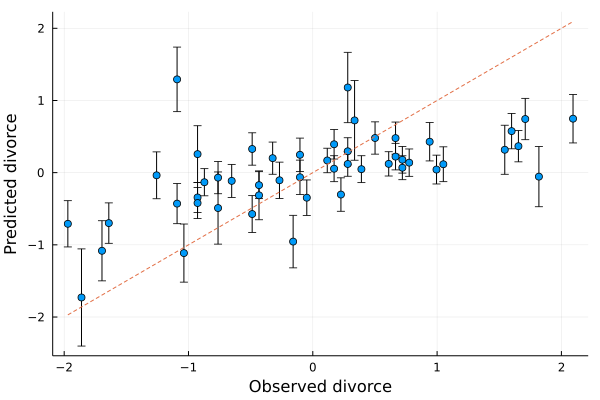

In [22]:
yerr = mu_PI[:,2] .- mu_mean
scatter(d.D, mu_mean; xlab="Observed divorce", ylab="Predicted divorce", yerr=yerr)
plot!(x->x; style=:dash)

Code 5.17

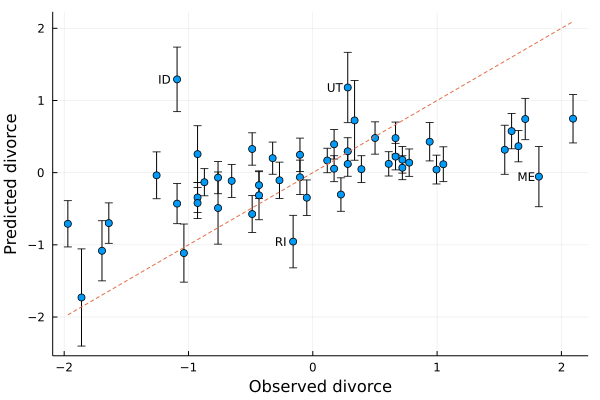

In [23]:
loc_flags = d.Loc .∈ (["ID", "UT", "RI", "ME"],);
loc_idxes = findall(loc_flags);
anns = [
    (d.D[idx] - 0.1, mu_mean[idx], (d.Loc[idx], 8))
    for idx in loc_idxes
]
annotate!(anns)

Code 5.18

In [24]:
Random.seed!(100)
N = 100
x_real = rand(Normal(), N)
x_spur = rand.(Normal.(x_real))
y = rand.(Normal.(x_real))
df = DataFrame(:y => y, :x_real => x_real, :x_spur => x_spur);

Code 5.19

In [25]:
d1 = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d = DataFrame(
    :D => standardize(ZScoreTransform, d1.Divorce),
    :M => standardize(ZScoreTransform, d1.Marriage),
    :A => standardize(ZScoreTransform, d1.MedianAgeMarriage),
);

@model function model_m5_3A(A, M, D)
    # A → D ← M
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
    # A → M
    σ_M ~ Exponential(1)
    aM ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ_M = @. aM + bAM * A
    M ~ MvNormal(μ_M, σ_M)
end

m5_3A = sample(model_m5_3A(d.A, d.M, d.D), NUTS(), 1000)
m5_3A_df = DataFrame(m5_3A)
precis(m5_3A_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │   0.002  0.1019  -0.1599  -0.0009    0.168        ▁▁▃██▄▁▁ │
│    aM │ -0.0002  0.0876   -0.141  -0.0011    0.138    ▁▁▂▃▅██▆▃▁▁▁ │
│    bA │ -0.6029  0.1556   -0.847  -0.6026  -0.3537      ▁▁▃▆██▅▃▁▁ │
│   bAM │ -0.6985  0.0986  -0.8573  -0.6975  -0.5438  ▁▁▂▄▆██▇▄▂▁▁▁▁ │
│    bM │ -0.0614  0.1564  -0.3031  -0.0576   0.1791    ▁▁▂▄██▇▃▁▁▁▁ │
│     σ │  0.8314  0.0905   0.6973   0.8253    0.982   ▁▂▅██▇▅▃▁▁▁▁▁ │
│   σ_M │  0.7135  0.0723   0.6091   0.7084   0.8318     ▁▂▅▇█▅▃▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 5.20

In [26]:
A_seq = range(-2, 2; length=30);

Code 5.21

In [27]:
s_M, s_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    push!(s_M, M)
    push!(s_D, D)
end

s_M = vcat(s_M'...)
s_D = vcat(s_D'...);

Code 5.22

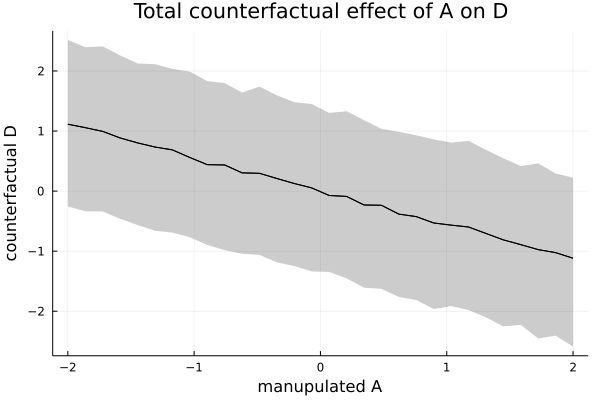

In [28]:
μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    A_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual D",
    title="Total counterfactual effect of A on D"
)

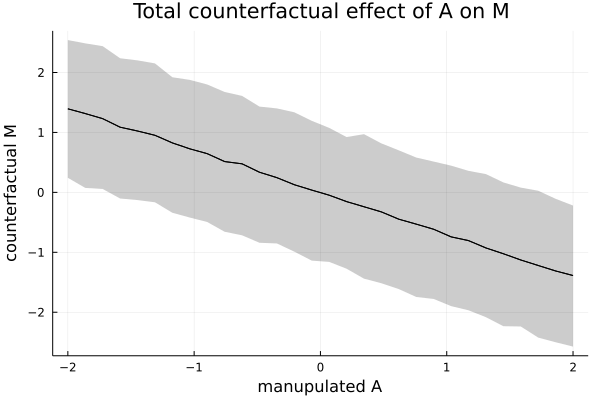

In [29]:
μ_M = mean.(eachcol(s_M))
PI_M = vcat(PI.(eachcol(s_M))'...)

plot(
    A_seq, [μ_M, μ_M]; 
    fillrange=PI_M, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual M",
    title="Total counterfactual effect of A on M"
)

Code 5.23

In [30]:
sim2_A = @. ([20, 30] - 26.1) / 1.24;
s2_M, s2_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * sim2_A), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * sim2_A + r.bM * M), r.σ))
    push!(s2_M, M)
    push!(s2_D, D)
end

s2_M = vcat(s2_M'...)
s2_D = vcat(s2_D'...);
mean(s2_D[:,2] - s2_D[:,1])

-4.534519568870829

Code 5.24

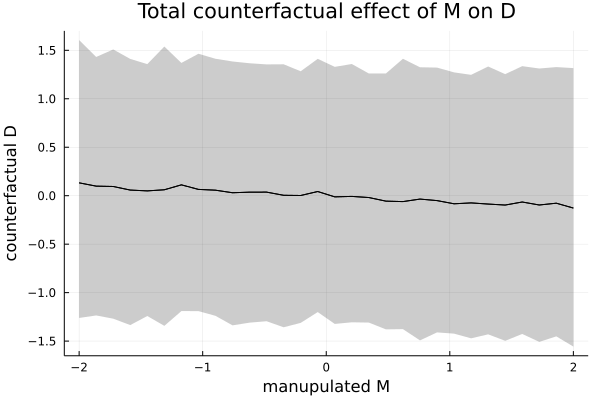

In [31]:
M_seq = range(-2, 2; length=30)
s_D = []

for r ∈ eachrow(m5_3A_df)
    # A is zero, so, we drop it from the μ term
    D = rand(MvNormal((@. r.a + r.bM * M_seq), r.σ))
    push!(s_D, D)
end

s_D = vcat(s_D'...);

μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    M_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated M", ylab="counterfactual D",
    title="Total counterfactual effect of M on D"
)

Code 5.25

In [32]:
A_seq = range(-2, 2; length=30);

Code 5.26

In [33]:
s_M = simulate(m5_3A_df, (r,a) -> Normal(r.aM + r.bAM*a), A_seq)
s_M = vcat(s_M'...);

Code 5.27

In [34]:
# joining M into dataframe with parameters
t = DataFrame(m5_3A_df)
t[!,:M] = collect(eachrow(s_M));

s_D = simulate(t, (r,(a,m)) -> Normal(r.a + r.bA*a + r.bM*r.M[m], r.σ), zip(A_seq, 1:30))
s_D = vcat(s_D'...);

# 5.2 Masked relationship

Code 5.28

In [35]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

describe(d)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,clade,,Ape,,Strepsirrhine,0
2,species,,A palliata,,Symphalangus syndactylus,0
3,kcal_per_g,0.641724,0.46,0.6,0.97,0
4,perc_fat,33.9903,3.93,36.84,55.51,0
5,perc_protein,16.4034,7.37,15.8,25.3,0
6,perc_lactose,49.6062,27.09,48.64,71.91,0
7,mass,14.7269,0.12,3.47,97.72,0
8,neocortex_perc,67.5759,55.16,68.85,76.3,12


Code 5.29

In [36]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:M] = standardize(ZScoreTransform, log.(d.mass))

# column contains missing values, need to propagate them on standartization
d[!,:N] = d.neocortex_perc
non_miss = findall(!ismissing, d.N);
d[non_miss,:N] = standardize(ZScoreTransform, disallowmissing(d.N[non_miss]));

Code 5.30

Expected to fail

In [37]:
@model function model_m5_5_draft(N, K)
    a ~ Normal(0, 1)
    bN ~ Normal(0, 1)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

try
    m5_5_draft = sample(model_m5_5_draft(d.N, d.K), NUTS(), 1000)
catch e
    if isa(e, MethodError)
        s = sprint(showerror, e)
        println(s)
    end
end

MethodError: no method matching MvNormal(::Vector{Union{Missing, Float64}}, ::Float64)
Closest candidates are:
  MvNormal(!Matched::Tracker.TrackedVector{var"#s52", A} where {var"#s52"<:Real, A}, ::Real) at /home/shmuma/.julia/packages/DistributionsAD/yw5cH/src/tracker.jl:462
  MvNormal(!Matched::AbstractVector{var"#s487"} where var"#s487"<:Real, ::Real) at deprecated.jl:70
  MvNormal(!Matched::Int64, ::Real) at deprecated.jl:70


Code 5.31

In [38]:
d.neocortex_perc

29-element Vector{Union{Missing, Float64}}:
 -2.0801960251136564
   missing
   missing
   missing
   missing
 -0.5086412889378672
 -0.5086412889378672
  0.010742472484833622
   missing
  0.21346968258853227
 -1.4619618058717947
 -0.9861392631490621
 -1.2156733770681267
  ⋮
  0.47483699478834385
   missing
  0.9757910098379835
   missing
 -0.007687273888229892
   missing
  0.6172486713074732
  0.8417564907611553
   missing
  0.44635465948451797
  1.4616661414914773
  1.3259561909261903

Code 5.32

In [39]:
dcc = d[completecases(d[!,[:K,:N,:M]]),:];

Code 5.33

In [40]:
m5_5_draft = sample(model_m5_5_draft(dcc.N, dcc.K), NUTS(), 1000);

Code 5.34

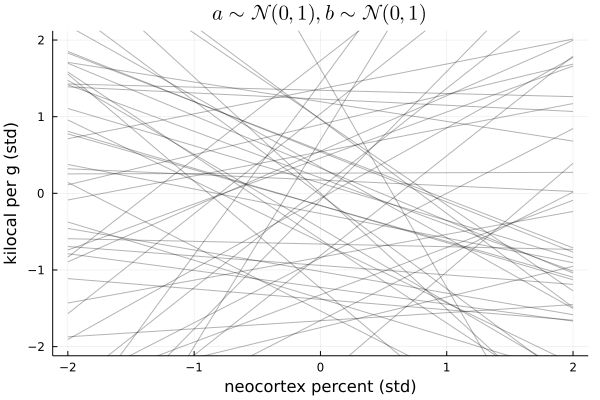

In [41]:
prior = sample(model_m5_5_draft(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)
xseq = [-2, 2]
μ = link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p = plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,1), b \sim \mathcal{N}(0,1)"
)
for y ∈ first(eachrow(μ), 50)
    plot!(p, xseq, y; c=:black, alpha=0.3)
end
p

Code 5.35

In [42]:
@model function model_m5_5(N, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

m5_5 = sample(model_m5_5(dcc.N, dcc.K), NUTS(), 1000)
m5_5_df = DataFrame(m5_5);

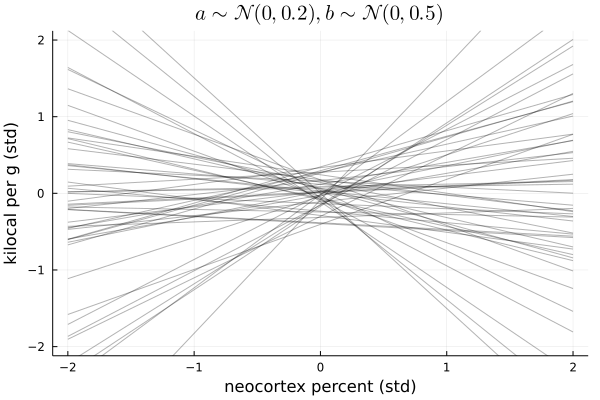

In [43]:
prior = sample(model_m5_5(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)

μ = link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p2 = plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,0.2), b \sim \mathcal{N}(0,0.5)"
)
for y ∈ first(eachrow(μ), 50)
    plot!(p2, xseq, y; c=:black, alpha=0.3)
end
p2

Code 5.36

In [44]:
precis(m5_5_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%     histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ 0.0341  0.1712  -0.2582  0.0324  0.3065  ▁▁▁▂▄▆█▆▃▂▁▁ │
│    bN │ 0.1363   0.239  -0.2486  0.1334  0.5227    ▁▁▂▅█▇▃▁▁▁ │
│     σ │  1.108  0.1985   0.8612  1.0778    1.45    ▁██▅▂▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 5.37

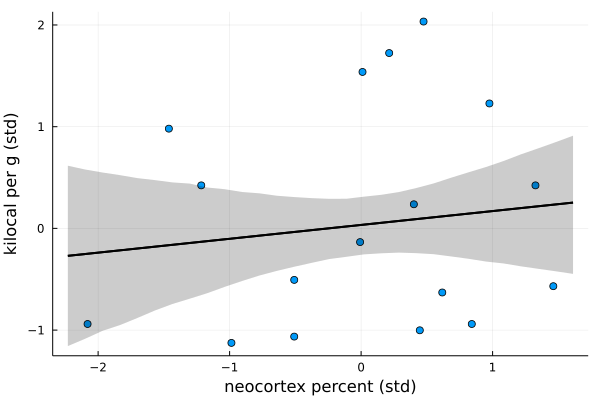

In [45]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = link(m5_5_df, [:a, :bN], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df dcc scatter(:N, :K; xlab="neocortex percent (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

Code 5.38

In [46]:
@model function model_m5_6(M, K)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bM * M
    K ~ MvNormal(μ, σ)
end

m5_6 = sample(model_m5_6(dcc.M, dcc.K), NUTS(), 1000)
m5_6_df = DataFrame(m5_6)
precis(m5_6_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.0452  0.1615  -0.2122   0.0389  0.3085    ▁▁▂▄▇█▆▄▂▁▁▁ │
│    bM │ -0.2673  0.2027  -0.5915  -0.2727  0.0577  ▁▁▂▄▆███▅▃▁▁▁▁ │
│     σ │  1.0601  0.1975   0.7949   1.0289  1.4031  ▁▂▆██▆▄▃▂▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


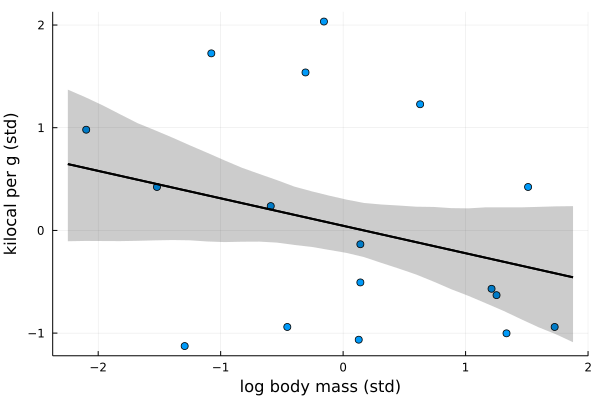

In [47]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = link(m5_6_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df dcc scatter(:M, :K; xlab="log body mass (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

In [48]:
@model function model_m5_7(N, M, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N + bM * M
    K ~ MvNormal(μ, σ)
end

m5_7 = sample(model_m5_7(dcc.N, dcc.M, dcc.K), NUTS(), 1000)
m5_7_df = DataFrame(m5_7)
precis(m5_7_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │  0.0664  0.1463  -0.1778   0.0711    0.302  ▁▂▃▇██▄▂▁▁▁ │
│    bM │ -0.6285  0.2483  -0.9994  -0.6536  -0.2093  ▁▂▅█▇▃▂▁▁▁▁ │
│    bN │     0.6  0.2716   0.1339   0.6089    1.018    ▁▁▂▄██▅▂▁ │
│     σ │  0.8726  0.1931   0.6398   0.8379   1.2128    ▁██▃▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 5.40

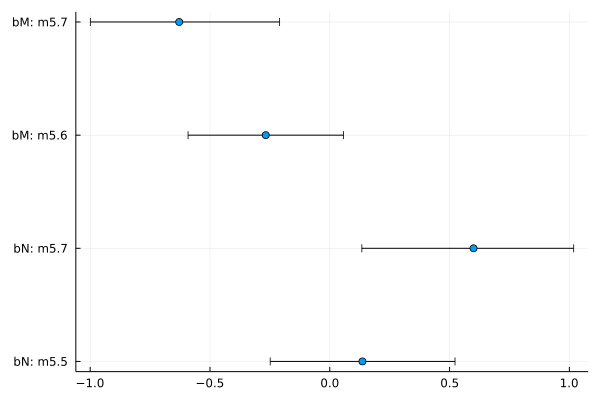

In [49]:
coeftab_plot(m5_7_df, m5_6_df, m5_5_df; pars=(:bM, :bN), names=("m5.7", "m5.6", "m5.5"))

Code 5.41

The code in the book corresponds to the bottom-right figure, which keeps N=0 (despite stated in the text).

Below is the code to produce the bottom-left figure (M=0).

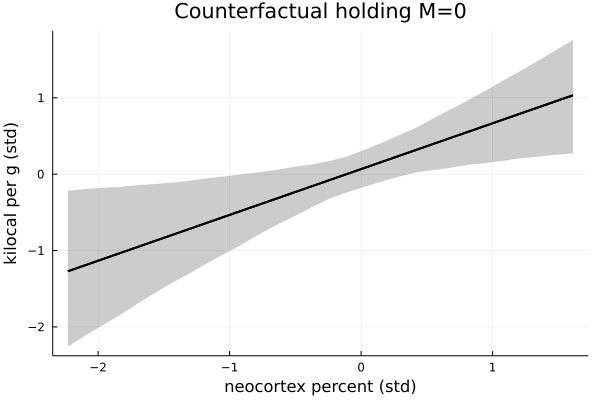

In [50]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = link(m5_7_df, [:a, :bN], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

plot(title="Counterfactual holding M=0", 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

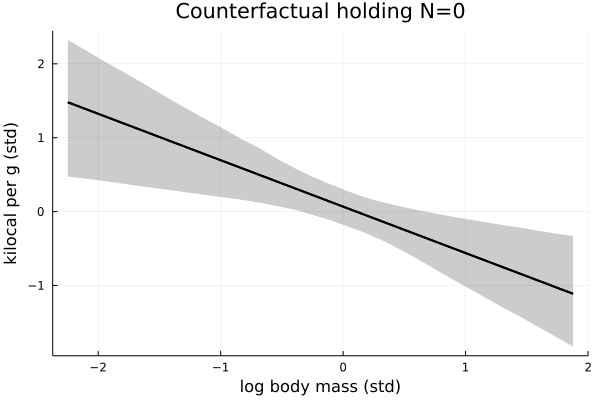

In [51]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = link(m5_7_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

plot(title="Counterfactual holding N=0", 
    xlab="log body mass (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

Code 5.42

In [52]:
# M → K ← N
# M → N
Random.seed!(100)
n = 100
M = rand(Normal(), n)
N = [rand(Normal(μ)) for μ ∈ M]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim = DataFrame(:K => K, :N => N, :M => M);

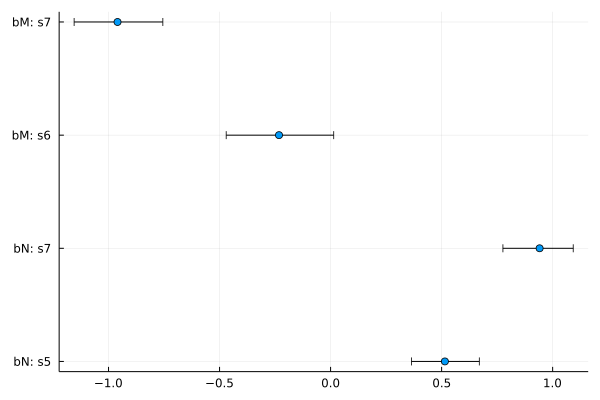

In [53]:
s5 = sample(model_m5_5(d_sim.N, d_sim.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim.M, d_sim.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim.N, d_sim.M, d_sim.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

Code 5.43

In [54]:
Random.seed!(100)

# M → K ← N
# N → M
n = 100
N = rand(Normal(), n)
M = [rand(Normal(μ)) for μ ∈ N]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim2 = DataFrame(:K => K, :N => N, :M => M);

# M → K ← N
# M ← U → N
n = 100
U = rand(Normal(), n)
N = [rand(Normal(μ)) for μ ∈ U]
M = [rand(Normal(μ)) for μ ∈ U]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim3 = DataFrame(:K => K, :N => N, :M => M);

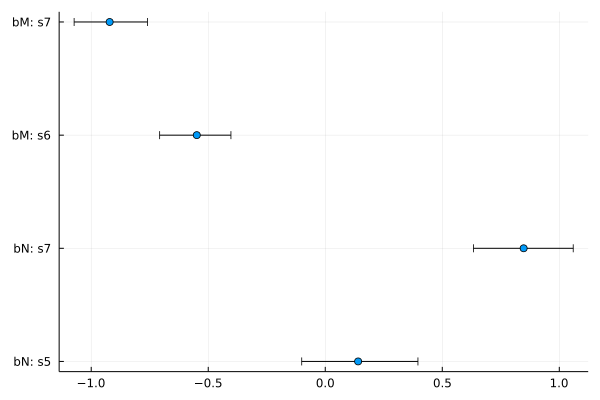

In [55]:
s5 = sample(model_m5_5(d_sim2.N, d_sim2.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim2.M, d_sim2.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim2.N, d_sim2.M, d_sim2.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

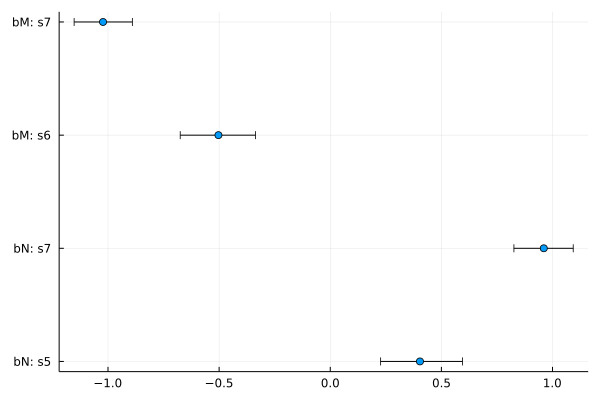

In [56]:
s5 = sample(model_m5_5(d_sim3.N, d_sim3.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim3.M, d_sim3.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim3.N, d_sim3.M, d_sim3.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

Code 5.44

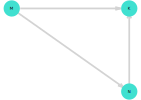

In [57]:
dag5_7 = Dagitty.DAG(:M => :K, :N => :K, :M => :N)
drawdag(dag5_7, [1, 0, 1], [0, 0, 1])

# equivalentDAGs is TODO in Dagitty.jl

# 5.3 Categorical variables

Code 5.45

In [58]:
d = DataFrame(CSV.File("data/Howell1.csv"))
describe(d)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,height,138.264,53.975,148.59,179.07,0,Float64
2,weight,35.6106,4.25242,40.0578,62.9926,0,Float64
3,age,29.3444,0.0,27.0,88.0,0,Float64
4,male,0.472426,0,0.0,1,0,Int64


Code 5.46

In [59]:
cnt = 10_000
μ_female = rand(Normal(178, 20), cnt)
μ_male = rand(Normal(178, 20), cnt) + rand(Normal(0, 10), cnt)
precis(DataFrame(:μ_female => μ_female, :μ_male => μ_male))

┌──────────┬────────────────────────────────────────────────────────┐
│    param │    mean      std     5.5%      50%    94.5%  histogram │
├──────────┼────────────────────────────────────────────────────────┤
│ μ_female │ 177.916  19.8439  146.319  177.704  209.809   ▁▁▄██▃▁▁ │
│   μ_male │ 177.735   22.197  142.547  177.727  213.312  ▁▁▅██▄▁▁▁ │
└──────────┴────────────────────────────────────────────────────────┘


Code 5.47

In [60]:
d[!,:sex] = ifelse.(d.male .== 1, 2, 1)
describe(d.sex)

Summary Stats:
Length:         544
Missing Count:  0
Mean:           1.472426
Minimum:        1.000000
1st Quartile:   1.000000
Median:         1.000000
3rd Quartile:   2.000000
Maximum:        2.000000
Type:           Int64


Code 5.48

In [61]:
@model function model_m5_8(sex, height)
    σ ~ Uniform(0, 50)
    a ~ MvNormal([178, 178], 20)
    height ~ MvNormal(a[sex], σ)
end

m5_8 = sample(model_m5_8(d.sex, d.height), NUTS(), 1000)
m5_8_df = DataFrame(m5_8)
precis(m5_8_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ 134.925  1.6176  132.457  134.839  137.415  ▁▁▁▂▃▇█▇▆▃▁▁▁ │
│  a[2] │ 142.628  1.6932  139.945  142.576  145.316   ▁▁▁▂▄▇██▅▂▁▁ │
│     σ │ 27.4051  0.8342  26.1216  27.4125  28.8383  ▁▁▂▄███▆▃▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 5.49

In [62]:
m5_8_df[!,:diff_fm] = m5_8_df[:,"a[1]"] - m5_8_df[:,"a[2]"]
precis(m5_8_df)

┌─────────┬────────────────────────────────────────────────────────────┐
│   param │    mean     std      5.5%      50%    94.5%      histogram │
├─────────┼────────────────────────────────────────────────────────────┤
│    a[1] │ 134.925  1.6176   132.457  134.839  137.415  ▁▁▁▂▃▇█▇▆▃▁▁▁ │
│    a[2] │ 142.628  1.6932   139.945  142.576  145.316   ▁▁▁▂▄▇██▅▂▁▁ │
│       σ │ 27.4051  0.8342   26.1216  27.4125  28.8383  ▁▁▂▄███▆▃▁▁▁▁ │
│ diff_fm │ -7.7037   2.308  -11.3153  -7.6808  -4.0109     ▁▁▃██▅▂▁▁▁ │
└─────────┴────────────────────────────────────────────────────────────┘


Code 5.50

In [63]:
d = DataFrame(CSV.File("data/milk.csv"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

levels(d.clade)

4-element Vector{String31}:
 "Ape"
 "New World Monkey"
 "Old World Monkey"
 "Strepsirrhine"

Code 5.51

In [64]:
d[!,:clade_id] = indexin(d.clade, levels(d.clade));

Code 5.52

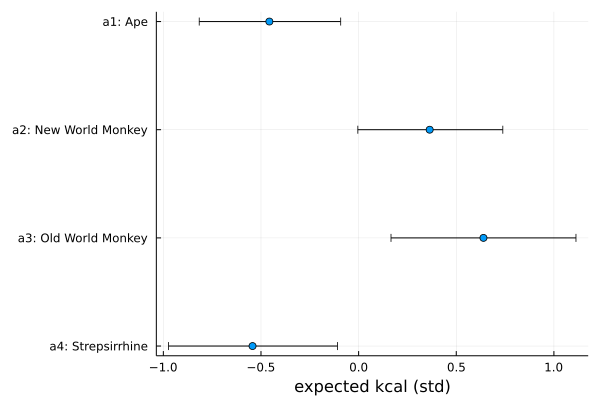

In [65]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g);
clade_counts = maximum(levels(d.clade_id))

@model function model_m5_9(clade_id, K)
    clade_μ = zeros(clade_counts)
    a ~ MvNormal(clade_μ, 0.5)
    σ ~ Exponential(1)
    K ~ MvNormal(a[clade_id], σ)
end

m5_9 = sample(model_m5_9(d.clade_id, d.K), NUTS(), 1000)
m5_9_df = DataFrame(m5_9)
# get rid of square brackets in a params
rename!(n -> replace(n, r"\[|\]" => ""), m5_9_df)

pars = [:a1, :a2, :a3, :a4]
p_names = map(v -> "$(v[1]): $(v[2])", zip(pars, levels(d.clade)))

coeftab_plot(m5_9_df; pars=pars, pars_names=p_names, xlab="expected kcal (std)")

Code 5.53

In [66]:
# it took me a while to find a seed which make Slytherin to stand out. 
# So it is just a seed, not the model property
Random.seed!(31)
d[!,:house] = sample(1:4, nrow(d));

Code 5.54

In [67]:
house_counts = maximum(levels(d.house))

@model function model_m5_10(clade_id, house, K)
    clade_μ = zeros(clade_counts)
    house_μ = zeros(house_counts)
    a ~ MvNormal(clade_μ, 0.5)
    h ~ MvNormal(house_μ, 0.5)
    σ ~ Exponential(1)
    μ = a[clade_id] .+ h[house]
    K ~ MvNormal(μ, σ)
end

m5_10 = sample(model_m5_10(d.clade_id, d.house, d.K), NUTS(), 1000)
m5_10_df = DataFrame(m5_10)
precis(m5_10_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.4983  0.2807  -0.9165  -0.5088  -0.0351      ▁▁▃▇█▆▄▁▁ │
│  a[2] │  0.2824  0.2874   -0.203   0.2816   0.7225      ▁▂▄▇█▆▄▁▁ │
│  a[3] │  0.6566  0.3311   0.1175   0.6597   1.1682  ▁▁▁▁▃▅███▄▂▁▁ │
│  a[4] │  -0.518  0.3104  -0.9895  -0.5226  -0.0099     ▁▂▅▇█▆▄▂▁▁ │
│  h[1] │ -0.0292  0.2937  -0.4857  -0.0238   0.4206   ▁▁▁▃▆██▅▂▁▁▁ │
│  h[2] │ -0.1539  0.3263   -0.651  -0.1561   0.3735    ▁▁▂▆▇█▆▃▂▁▁ │
│  h[3] │ -0.1388  0.3063  -0.6165  -0.1344   0.3677     ▁▂▅██▇▄▂▁▁ │
│  h[4] │  0.2955  0.2835  -0.1574    0.298   0.7404    ▁▁▁▁▃▆█▇▃▁▁ │
│     σ │  0.7929    0.12   0.6192   0.7768   0.9898     ▁▅█▆▄▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘
